In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
import numpy as np

In [2]:
house_data = pd.read_csv('kc_house_data.csv')

Our dataset is only 2.5 MBs, so we skip the subsampling step here.

In [3]:
house_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB


In [4]:
house_data['sqft_basement'].value_counts().head()

0.0      12826
?          454
600.0      217
500.0      209
700.0      208
Name: sqft_basement, dtype: int64

454 of our entries list basement size as '?'. Since we don't know whether or not these houses even have basements, and we have 21,597 entries anyway, we choose to drop these.

In [5]:
house_data = house_data[house_data.sqft_basement != '?']
house_data['sqft_basement'].value_counts().head()

0.0      12826
600.0      217
500.0      209
700.0      208
800.0      201
Name: sqft_basement, dtype: int64

In [6]:
house_data['view'].isna().sum()

61

We have 61 NaN values for view. Since this is still not statistically significant, we choose to discard the afflicted rows. 

In [7]:
house_data = house_data.dropna(subset=['view'])
house_data['view'].isna().sum()

0

In [8]:
house_data['yr_renovated'].value_counts().head()

0.0       16618
2014.0       69
2003.0       31
2013.0       31
2007.0       30
Name: yr_renovated, dtype: int64

Since so many values here are 0 and we don't want to make any unsafe assumptions, we elect to drop this column entirely.

Zipcode and longitude have a strong negative correlation with each other, and we expect latitude/longitude to be far more useful predictors than zipcode. So we choose to drop zipcode as well.

We drop sqft_above and sqft_living15 in favor of sqft_living as well, due to their high multicollinearity. 

In [9]:
house_data = house_data.drop('yr_renovated', axis=1)
house_data = house_data.drop('zipcode', axis=1)
house_data = house_data.drop('sqft_above', axis=1)
house_data = house_data.drop('sqft_living15', axis=1)
house_data = house_data.drop('grade', axis=1)
#Bathrooms and bedrooms have high correlation with sqft_living.
#However, we choose not to remove them yet. Maybe experiment with that?
house_data.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition',
       'sqft_basement', 'yr_built', 'lat', 'long', 'sqft_lot15'],
      dtype='object')

Okay, we just scrubbed a lot of data--how do the remaining columns correlate with each other?

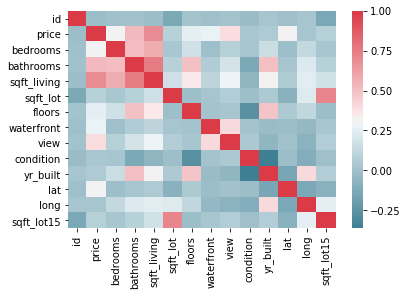

In [10]:
color_map = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(house_data.corr(), cmap=color_map)

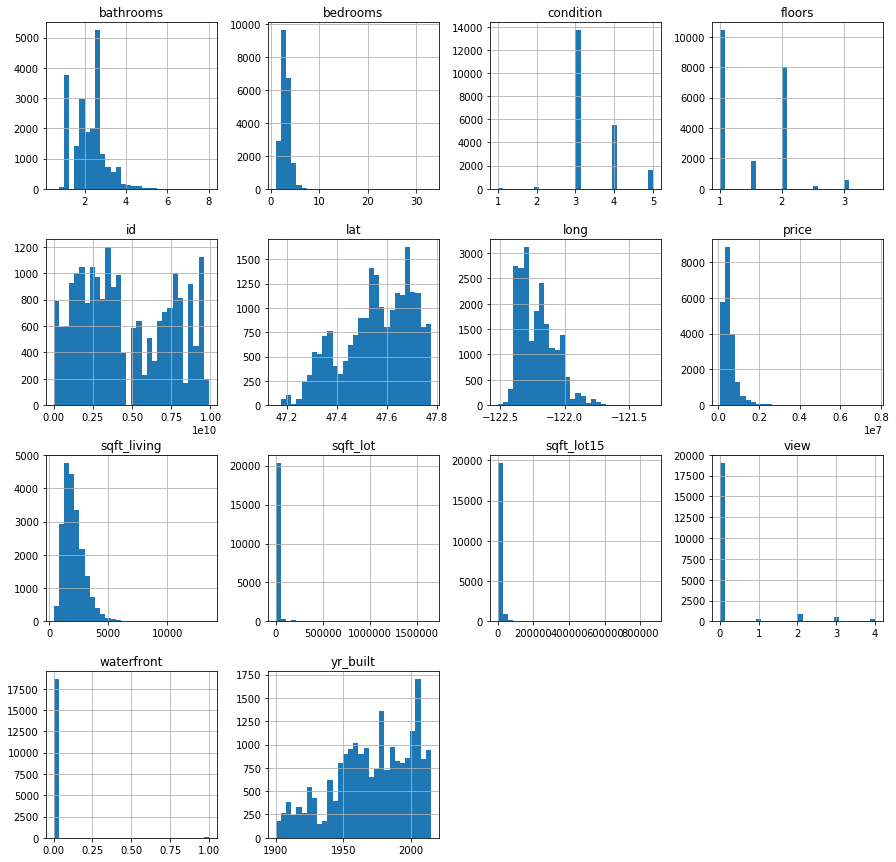

In [11]:
_ = house_data.hist(figsize=(15,15), bins=30)

In [12]:
# get a simple linear regression model for price and sqft_living
x = np.array(house_data['sqft_living'])
y = np.array(house_data['price'])

In [13]:
formula = 'y~x'
model = ols(formula=formula, data=house_data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.493
Model:                            OLS   Adj. R-squared:                  0.493
Method:                 Least Squares   F-statistic:                 2.048e+04
Date:                Tue, 16 Apr 2019   Prob (F-statistic):               0.00
Time:                        10:47:07   Log-Likelihood:            -2.9287e+05
No. Observations:               21082   AIC:                         5.857e+05
Df Residuals:                   21080   BIC:                         5.858e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -4.327e+04   4456.393     -9.709      0.000    -5.2e+04   -3.45e+04
x            280.4877      1.960    143.116      0.000     276.646     284.329
==============================================================================
Omnibus:                    14303.984   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           509767.330
Skew:                           2.786   Prob(JB):                         0.00
Kurtosis:                      26.437   Cond. No.                     5.63e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.63e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [14]:
linreg = LinearRegression()
linreg.fit(x.reshape(-1,1), y.reshape(-1,1))

y_hat = linreg.predict(x.reshape(-1,1))

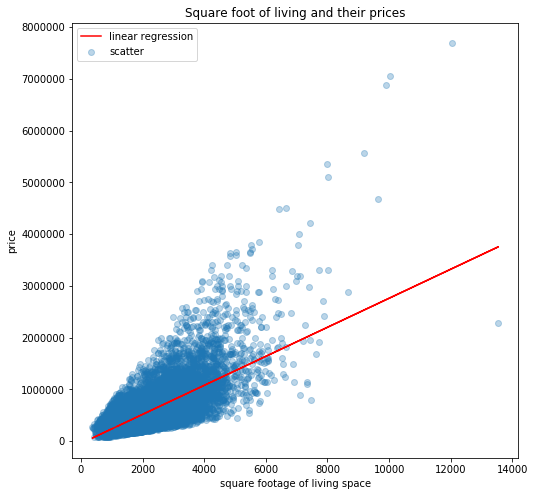

In [15]:
plt.figure(figsize=(8,8))
plt.scatter(x,y, label='scatter', alpha = 0.3)
plt.plot(x, y_hat, color='red', label='linear regression')
plt.title('Square foot of living and their prices')
plt.legend()
plt.xlabel('square footage of living space')
plt.ylabel('price')
plt.show()

In [16]:
# remove strong outliers in sqft_living and bedrooms
house_data = house_data.drop(house_data[house_data['sqft_living'] > 12000].index)
house_data = house_data.drop(house_data[house_data['bedrooms']>30].index)

house_data.describe(), house_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21079 entries, 0 to 21596
Data columns (total 16 columns):
id               21079 non-null int64
date             21079 non-null object
price            21079 non-null float64
bedrooms         21079 non-null int64
bathrooms        21079 non-null float64
sqft_living      21079 non-null int64
sqft_lot         21079 non-null int64
floors           21079 non-null float64
waterfront       18746 non-null float64
view             21079 non-null float64
condition        21079 non-null int64
sqft_basement    21079 non-null object
yr_built         21079 non-null int64
lat              21079 non-null float64
long             21079 non-null float64
sqft_lot15       21079 non-null int64
dtypes: float64(7), int64(7), object(2)
memory usage: 2.7+ MB


(                 id         price      bedrooms     bathrooms   sqft_living  \
 count  2.107900e+04  2.107900e+04  21079.000000  21079.000000  21079.000000   
 mean   4.582953e+09  5.398200e+05      3.370701      2.115375   2079.365198   
 std    2.876456e+09  3.632292e+05      0.901742      0.766051    911.933855   
 min    1.000102e+06  7.800000e+04      1.000000      0.500000    370.000000   
 25%    2.123700e+09  3.220000e+05      3.000000      1.750000   1428.500000   
 50%    3.904980e+09  4.500000e+05      3.000000      2.250000   1910.000000   
 75%    7.312300e+09  6.450000e+05      4.000000      2.500000   2550.000000   
 max    9.900000e+09  7.060000e+06     11.000000      7.750000  10040.000000   
 
            sqft_lot        floors    waterfront          view     condition  \
 count  2.107900e+04  21079.000000  18746.000000  21079.000000  21079.000000   
 mean   1.506354e+04      1.493524      0.007522      0.233028      3.409744   
 std    4.112679e+04      0.539254    

In [17]:
from datetime import datetime

house_data['date'] = pd.to_datetime(house_data['date'])

In [18]:
house_data['date'].sort_values()

#dates are in a one year span so prices should not be too affected by 

2485    2014-05-02
17041   2014-05-02
16866   2014-05-02
19661   2014-05-02
3710    2014-05-02
19051   2014-05-02
5652    2014-05-02
8883    2014-05-02
312     2014-05-02
172     2014-05-02
8293    2014-05-02
16302   2014-05-02
3719    2014-05-02
5608    2014-05-02
19814   2014-05-02
2578    2014-05-02
20133   2014-05-02
6705    2014-05-02
18675   2014-05-02
502     2014-05-02
15113   2014-05-02
5950    2014-05-02
4331    2014-05-02
7954    2014-05-02
12354   2014-05-02
10689   2014-05-02
15542   2014-05-02
7935    2014-05-02
16909   2014-05-02
4959    2014-05-02
           ...    
4272    2015-05-13
837     2015-05-13
11863   2015-05-13
8616    2015-05-13
1096    2015-05-13
14778   2015-05-13
817     2015-05-13
3766    2015-05-13
12875   2015-05-13
7887    2015-05-13
11899   2015-05-13
3065    2015-05-13
18841   2015-05-13
8474    2015-05-13
6005    2015-05-13
20221   2015-05-13
20456   2015-05-14
12623   2015-05-14
15797   2015-05-14
17383   2015-05-14
7891    2015-05-14
19381   2015

In [19]:
house_data = house_data.drop(house_data[house_data['price'] > 1502000].index)
house_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20575 entries, 0 to 21596
Data columns (total 16 columns):
id               20575 non-null int64
date             20575 non-null datetime64[ns]
price            20575 non-null float64
bedrooms         20575 non-null int64
bathrooms        20575 non-null float64
sqft_living      20575 non-null int64
sqft_lot         20575 non-null int64
floors           20575 non-null float64
waterfront       18293 non-null float64
view             20575 non-null float64
condition        20575 non-null int64
sqft_basement    20575 non-null object
yr_built         20575 non-null int64
lat              20575 non-null float64
long             20575 non-null float64
sqft_lot15       20575 non-null int64
dtypes: datetime64[ns](1), float64(7), int64(7), object(1)
memory usage: 2.7+ MB


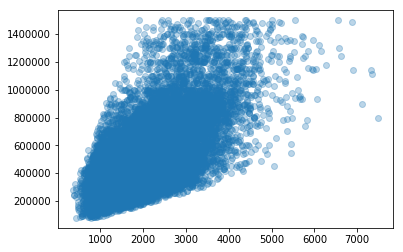

In [21]:
plt.scatter(house_data['sqft_living'], house_data['price'], alpha=0.3)